In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchinfo import summary

from dataset import MnistDataset
import training as f
from vae.vanilla_vae import VAE

c:\Users\wojci\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [3]:
BATCH_SIZE = 256

N_PIXELS = 28 * 28
LATENT_SIZE = 32
N_NEURONS = 64

LR = 2e-3
EPOCHS = 40
MAX_PATIENCE = 6

In [4]:
t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

train_data = MnistDataset('train', t)
val_data = MnistDataset('val', t)
test_data = MnistDataset('test', t)

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [5]:
result_dir = 'results/'
name = 'vae'

In [6]:
encoder = nn.Sequential(
    nn.Linear(N_PIXELS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, 2 * LATENT_SIZE)
).to(device)

decoder = nn.Sequential(
    nn.Linear(LATENT_SIZE, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_PIXELS)
).to(device)

model = VAE(encoder, decoder, LATENT_SIZE).to(device)

# Print summary
print("ENCODER:\n", summary(encoder, (N_PIXELS,)))
print("\nDECODER:\n", summary(decoder, (LATENT_SIZE,)))

ENCODER:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64]                      --
├─Linear: 1-1                            [64]                      50,240
├─LeakyReLU: 1-2                         [64]                      --
├─Linear: 1-3                            [64]                      4,160
├─LeakyReLU: 1-4                         [64]                      --
├─Linear: 1-5                            [64]                      4,160
Total params: 58,560
Trainable params: 58,560
Non-trainable params: 0
Total mult-adds (M): 3.75
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.23
Estimated Total Size (MB): 0.24

DECODER:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [784]                     --
├─Linear: 1-1                            [64]                      2,112
├─LeakyReLU: 1-2                         [64]  

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

nll_val = f.training(device, result_dir + name, MAX_PATIENCE, EPOCHS, model, optimizer, train_loader, val_loader)

Epoch: 0, val_loss=0.002072322744131088


KeyboardInterrupt: 

FINAL LOSS: nll=0.001621407625079155


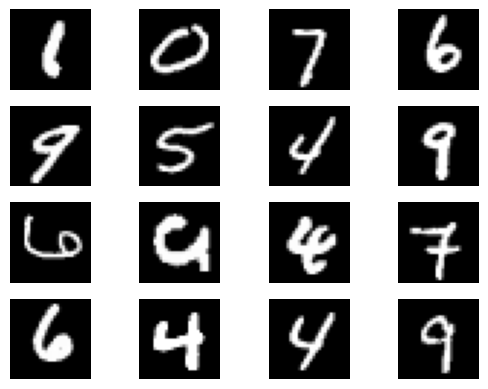

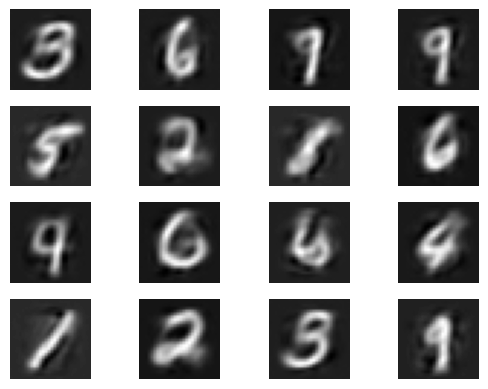

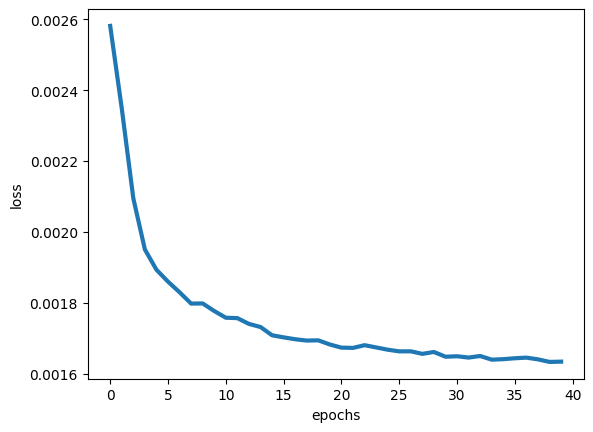

In [ ]:
test_loss = f.evaluation(device, test_loader, name=result_dir+name)
file = open(result_dir+name + '_test_loss.txt', 'w')
file.write(str(test_loss))
file.close()

f.samples_real(result_dir + name, test_loader)
f.samples_generated(result_dir + name)

f.plot_curve(result_dir + name, nll_val)

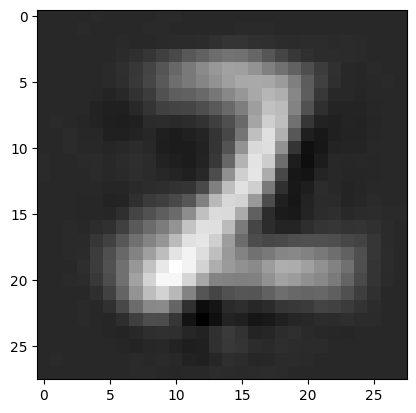

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_new = model.sample(1)
x = x_new.detach().numpy()
x = np.reshape(x, (28, 28))

plt.imshow(x, cmap='gray')
plt.show()